now only fish/engine

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

def get_global_min_max(data_folder):
    # Initialize variables to store global min and max values for x and y
    global_x_min, global_x_max = float('inf'), float('-inf')
    global_y_min, global_y_max = float('inf'), float('-inf')
    
    # Loop through all files to compute global min and max values for x and y
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path)
        
        # Filter for the two target statuses
        target_labels = ["Under way using engine", "Engaged in fishing"]
        df = df[df['Navigational status'].isin(target_labels)]
        
        # Calculate x and y components of velocity
        df['x'] = df['SOG'] * np.cos(np.deg2rad(df['COG']))
        df['y'] = df['SOG'] * np.sin(np.deg2rad(df['COG']))
        
        # Update global min and max for x and y
        global_x_min = min(global_x_min, df['x'].min())
        global_x_max = max(global_x_max, df['x'].max())
        global_y_min = min(global_y_min, df['y'].min())
        global_y_max = max(global_y_max, df['y'].max())
    
    return global_x_min, global_x_max, global_y_min, global_y_max

def preprocess_file(file_path, global_x_min, global_x_max, global_y_min, global_y_max):
    df = pd.read_csv(file_path)
    
    # Filter for the two target statuses
    target_labels = ["Under way using engine", "Engaged in fishing"]
    df = df[df['Navigational status'].isin(target_labels)]
    
    # Skip files with no valid data
    if df.empty:
        return None, None
    
    # Normalize SOG to [0, 1] range
    sog_min, sog_max = 0, 15  # Adjust the range based on your dataset
    df['SOG'] = (df['SOG'] - sog_min) / (sog_max - sog_min)

    # Cyclic encoding of circular values
    df['COG_sin'] = np.sin(np.deg2rad(df['COG']))
    df['COG_cos'] = np.cos(np.deg2rad(df['COG']))
    df['Heading_sin'] = np.sin(np.deg2rad(df['Heading']))
    df['Heading_cos'] = np.cos(np.deg2rad(df['Heading']))

    # Calculate x and y components of velocity
    df['x'] = df['SOG'] * df['COG_cos']
    df['y'] = df['SOG'] * df['COG_sin']
    
    # Normalize x and y using global min and max values
    df['x'] = (df['x'] - global_x_min) / (global_x_max - global_x_min)
    df['y'] = (df['y'] - global_y_min) / (global_y_max - global_y_min)

    # Extract relevant features and target
    features = df[['SOG', 'COG_sin', 'COG_cos', 'Heading_sin', 'Heading_cos', 'x', 'y']].values
    target = df['Navigational status'].iloc[0]  # All rows in the file have the same status
    
    return features, target

# Main data loading function with undersampling
def load_data(data_folder):
    X, y = [], []
    
    # First pass: Get global min and max for x and y
    global_x_min, global_x_max, global_y_min, global_y_max = get_global_min_max(data_folder)
    
    # Second pass: Normalize x and y values in each file
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        features, target = preprocess_file(file_path, global_x_min, global_x_max, global_y_min, global_y_max)
        if features is not None:
            X.append(features)
            y.append(target)
    
    # Encode target labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Apply undersampling to balance the classes
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X.reshape(X.shape[0], -1), y)  # Reshape X to 2D for undersampling
    
    # Reshape X back to its original 3D shape after undersampling
    X_resampled = X_resampled.reshape(X_resampled.shape[0], X.shape[1], X.shape[2])
    
    return X_resampled, y_resampled, label_encoder

# Build Bi-directional LSTM model
def build_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, input_shape=input_shape, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Main script
if __name__ == "__main__":
    data_folder = "time_sets_st_shortened"
    X, y, label_encoder = load_data(data_folder)
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Ensure consistent sequence length
    max_sequence_length = max([len(sequence) for sequence in X_train])
    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_sequence_length, dtype='float32', padding='post')
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_sequence_length, dtype='float32', padding='post')
    
    # Build and train the model
    model = build_model((X_train.shape[1], X_train.shape[2]))
    model.build((None, X_train.shape[1], X_train.shape[2]))  # Explicitly build the model
    model.summary()  # Now you can print the summary after calling model.build()
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Save the model and label encoder
    model.save("vessel_navigational_status_bi_lstm_model.h5")
    with open("label_encoder.pkl", "wb") as f:
        import pickle
        pickle.dump(label_encoder, f)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 90, 128)          36864     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 1

56/56 [==============================] - 2s 18ms/step
F1 Score: 0.7758


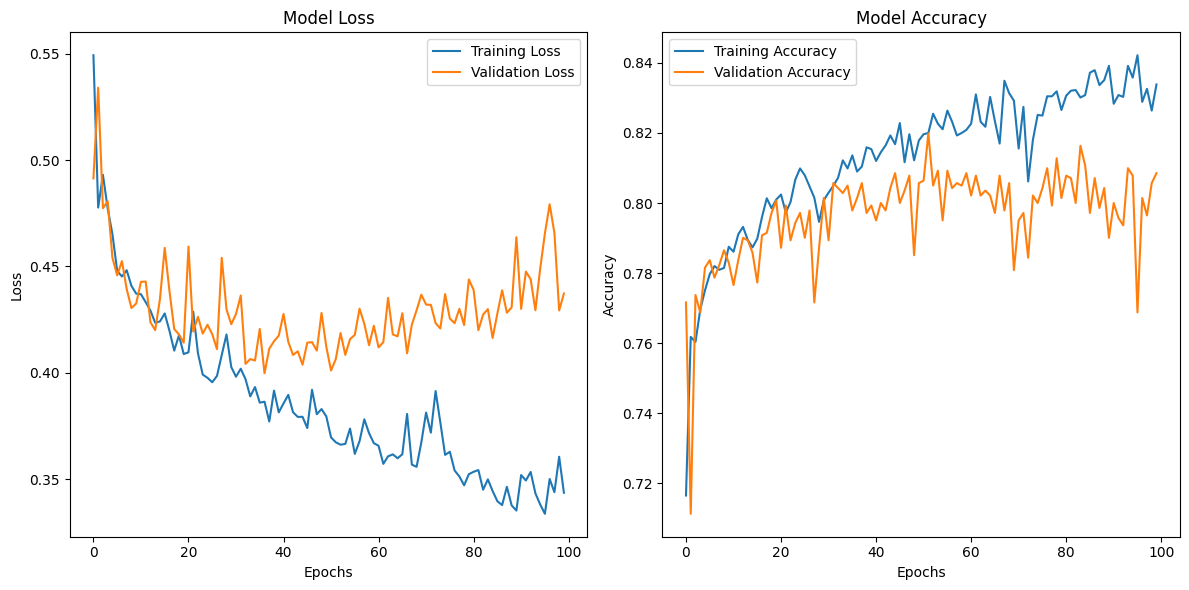

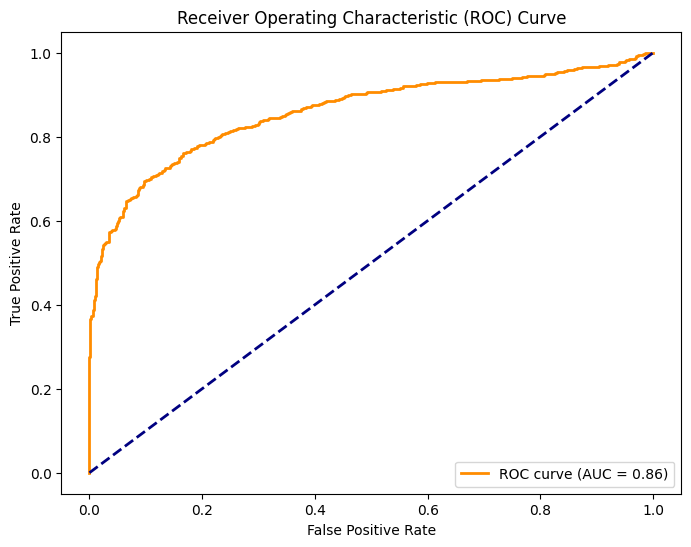

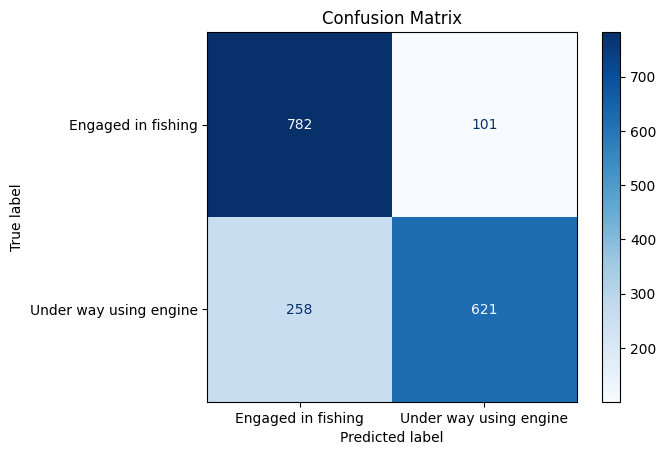

Test Accuracy: 0.7963


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Evaluate the model on training data for learning curve
# history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

# Plot Learning Curve (Loss and Accuracy)
def plot_learning_curve(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot ROC Curve
def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Main Evaluation Script
if __name__ == "__main__":
    # Make predictions on test set
    y_pred_probs = model.predict(X_test)  # Predicted probabilities
    y_pred = (y_pred_probs > 0.5).astype("int32")  # Predicted classes (threshold 0.5)

    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")

    # Learning Curve Plot
    plot_learning_curve(history)

    # ROC Curve Plot
    plot_roc_curve(y_test, y_pred_probs)

    # Confusion Matrix Plot
    plot_confusion_matrix(y_test, y_pred)
    
    # Optional: Accuracy Score
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
